50小时上行收益占总收益的数量比例

In [1]:
import polars as pl

# 读取数据
data = pl.read_parquet("hourly_data.pa")

# 设置窗口大小
window_size = 50  # 过去 50 小时

df = data.sort('open_time').sort("symbol")

# 计算每个小时的收益率
df = df.with_columns([
    (pl.col("close") / pl.col("close").shift(1) - 1).over("symbol").alias("returns")
])

# 只保留下行收益率（当收益率为负时，设为NaN）
df = df.with_columns([
    pl.when(pl.col("returns") < 0).then(pl.col("returns")).otherwise(None).alias("downside_returns")
])

# 计算窗口内的总收益率和和下行收益率数量
df = df.with_columns([
    pl.col("returns").cast(pl.Float32).rolling_sum(window_size, min_periods=1).over("symbol").alias("total_sum"),
    pl.col("downside_returns").is_not_null().cast(pl.Float32).rolling_sum(window_size, min_periods=1).over("symbol").alias("downside_count")
])

# 计算下行收益率占总收益率的比例
df = df.with_columns([
    (pl.col("downside_count") / pl.col("total_sum")).alias("downside_ratio")
])

# 打印结果
df


open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol,returns,downside_returns,total_sum,downside_count,downside_ratio
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str,f64,f64,f32,f32,f32
2022-09-09 13:00:00,0.4728,0.4874,0.3663,0.451,6.5705837e7,2022-09-09 13:59:59.999,2.8487e7,124200,3.3701922e7,1.4632e7,"""1000LUNCUSDT""",null,null,null,0.0,null
2022-09-09 14:00:00,0.451,0.4609,0.4277,0.4592,4.1316126e7,2022-09-09 14:59:59.999,1.8355e7,94104,2.0298138e7,9.0220e6,"""1000LUNCUSDT""",0.018182,null,0.018182,0.0,0.0
2022-09-09 15:00:00,0.4594,0.4734,0.4416,0.4555,4.4134479e7,2022-09-09 15:59:59.999,2.0198e7,103417,2.2353913e7,1.0239e7,"""1000LUNCUSDT""",-0.008057,-0.008057,0.010124,1.0,98.772003
2022-09-09 16:00:00,0.4554,0.458,0.4175,0.4297,4.6242265e7,2022-09-09 16:59:59.999,2.0187e7,84951,2.1467246e7,9.3760e6,"""1000LUNCUSDT""",-0.056641,-0.056641,-0.046517,2.0,-42.995285
2022-09-09 17:00:00,0.4297,0.4418,0.4071,0.4156,2.661109e7,2022-09-09 17:59:59.999,1.1376e7,50896,1.2655405e7,5.4132e6,"""1000LUNCUSDT""",-0.032814,-0.032814,-0.07933,3.0,-37.816563
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-12-31 19:00:00,0.1494,0.1498,0.1494,0.1496,748908.5,2022-12-31 19:59:59.999,112011.25443,882,481198.1,71987.20389,"""ZRXUSDT""",0.001339,null,-0.036684,26.0,-708.757751
2022-12-31 20:00:00,0.1496,0.1497,0.1494,0.1496,501195.0,2022-12-31 20:59:59.999,74979.34106,751,282290.8,42242.69096,"""ZRXUSDT""",0.0,null,-0.03604,25.0,-693.67395
2022-12-31 21:00:00,0.1496,0.1497,0.149,0.149,413737.4,2022-12-31 21:59:59.999,61817.02306,583,132775.7,19839.82814,"""ZRXUSDT""",-0.004011,-0.004011,-0.030386,25.0,-822.754578


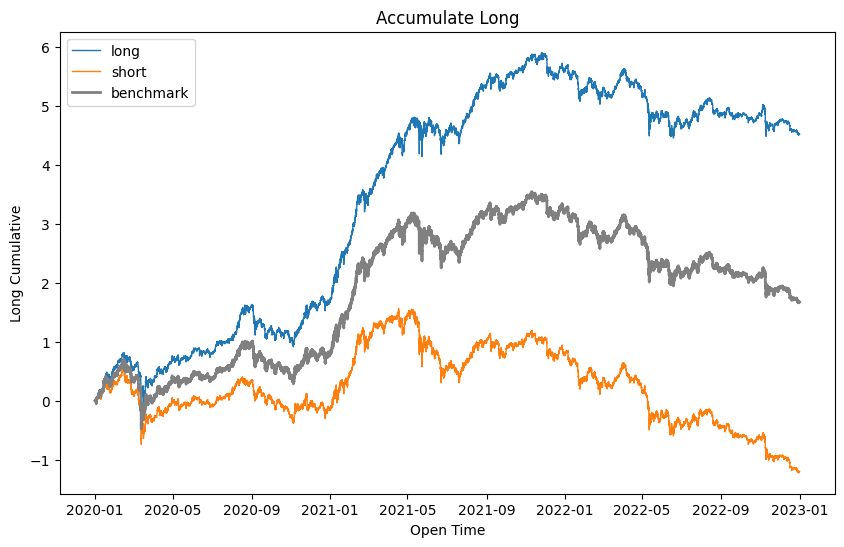

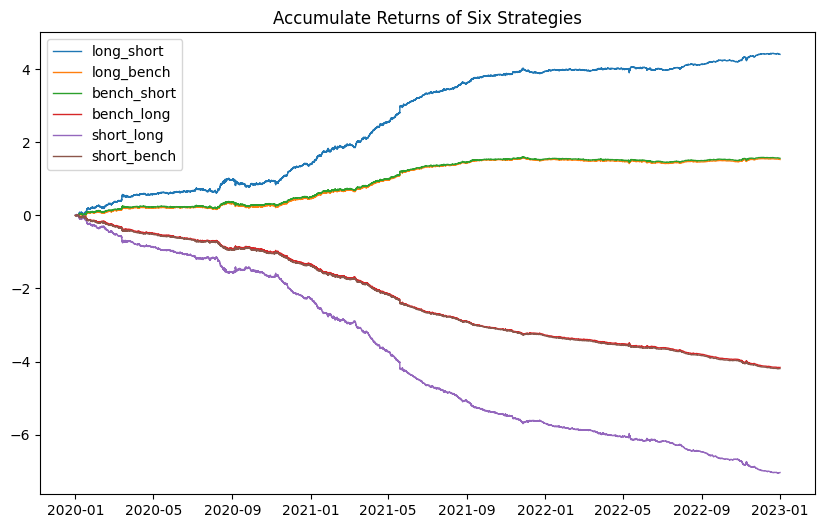

long: 
ann_return = 1.5044  sharpe = 1.337  maxdd = 0.5807  calmar_ratio = 2.5909  

short: 
ann_return = -0.3999  sharpe = -0.3731  maxdd = 1.0853  calmar_ratio = -0.3684  

bench: 
ann_return = 0.5575  sharpe = 0.513  maxdd = 0.6895  calmar_ratio = 0.8085  

long_short: 
ann_return = 1.4663  sharpe = 4.4784  maxdd = 0.1218  calmar_ratio = 12.0379  

long_bench: 
ann_return = 0.5089  sharpe = 3.0924  maxdd = 0.1054  calmar_ratio = 4.8295  

bench_long: 
ann_return = -1.3849  sharpe = -8.4156  maxdd = 4.125  calmar_ratio = -0.3357  

short_long: 
ann_return = -2.3423  sharpe = -7.1539  maxdd = 6.9037  calmar_ratio = -0.3393  

short_bench: 
ann_return = -1.3954  sharpe = -8.4708  maxdd = 4.1549  calmar_ratio = -0.3358  

bench_short: 
ann_return = 0.5194  sharpe = 3.1529  maxdd = 0.1022  calmar_ratio = 5.0843  



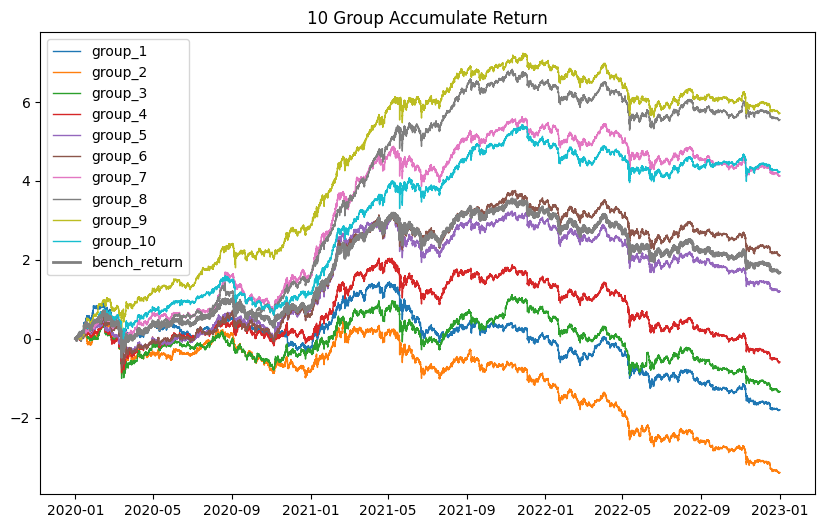

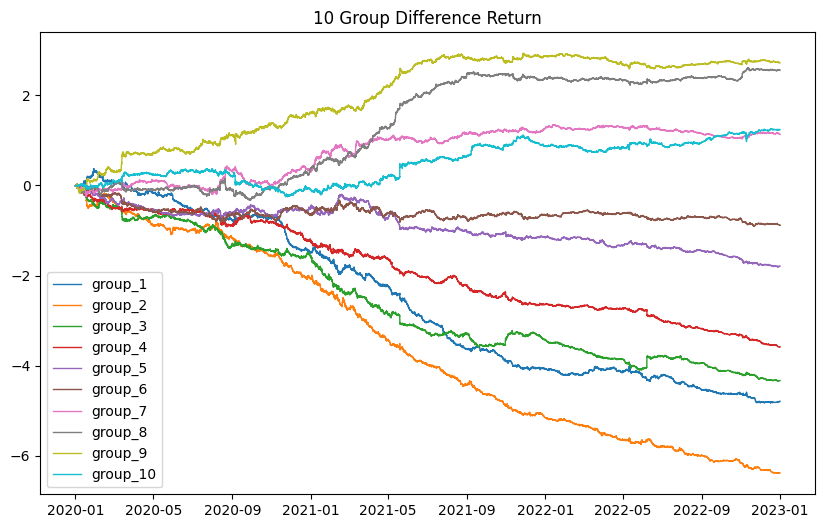

group_1: 
ann_return = -0.6011  sharpe = -0.5549  maxdd = 1.3368  calmar_ratio = -0.4496  

group_2: 
ann_return = -1.1307  sharpe = -1.0166  maxdd = 2.547  calmar_ratio = -0.4439  

group_3: 
ann_return = -0.4471  sharpe = -0.3908  maxdd = 1.1703  calmar_ratio = -0.382  

group_4: 
ann_return = -0.1974  sharpe = -0.1729  maxdd = 0.9025  calmar_ratio = -0.2187  

group_5: 
ann_return = 0.3994  sharpe = 0.3475  maxdd = 0.8023  calmar_ratio = 0.4978  

group_6: 
ann_return = 0.7016  sharpe = 0.6056  maxdd = 0.8381  calmar_ratio = 0.8371  

group_7: 
ann_return = 1.3729  sharpe = 1.1701  maxdd = 0.6634  calmar_ratio = 2.0694  

group_8: 
ann_return = 1.8477  sharpe = 1.5786  maxdd = 0.5846  calmar_ratio = 3.1605  

group_9: 
ann_return = 1.9025  sharpe = 1.5854  maxdd = 0.4537  calmar_ratio = 4.1931  

group_10: 
ann_return = 1.4085  sharpe = 1.2063  maxdd = 0.6105  calmar_ratio = 2.307  

-----------------------------------------
group_difference_1: 
ann_return = -1.5966  sharpe = -4.027

In [2]:
factors = df.select(['open_time', 'symbol', 'downside_ratio'])

from factor_analysis.factor_analysis import FactorAnalysis

# 使用示例
analysis = FactorAnalysis(factors, data)
analysis.run_full_analysis()